# Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 05.10.2021

Мягкий дедлайн: 23:59MSK 19.10.2021

Жесткий дедлайн: 23:59MSK 23.10.2021

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{penalty} = M_{full} \cdot 0.85^{t/1440}$, где $M_{full}$ &mdash; полная оценка за работу без учета штрафа, а $t$ &mdash; время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше **8.5**, а если сдать перед самым жестким дедлайном, то ваш максимум &mdash; **5.22** балла.

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
from IPython.display import display, clear_output

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader


import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('year_pred.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [80]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [4]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 9.5102


In [114]:
print("Train:", mean_squared_error(y_train, [y_train.mean()] * y_train.shape[0], squared=False))
print("Test:", mean_squared_error(y_test, [y_train.mean()] * y_test.shape[0], squared=False))

Train: 10.939755150678016
Test: 10.85246390513634


## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знайте, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [6]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

### Часть первая. Optuna

Практически весь код данной части был взять из гитхаба разработчиков библиотеки: https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py

Отличия заключаются в подстраивании кода под специфику конкретной задачи, в частности, уход от задачи классификации.

**1. Подключение библиотек**

In [78]:
import os
import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms

**2. Иниицилизация констант**

In [79]:
DEVICE = torch.device("cpu")
BATCH_SIZE = 128
EPOCHS = 10
N_TRAIN_EXAMPLES = BATCH_SIZE * 70
N_VALID_EXAMPLES = BATCH_SIZE * 40
EVAL_BATCH_SIZE = 128
SEED = 42
WEIGHT_DECAY = 1e-3
GAMMA = 0.9995

**3. Устройство данных**

Класс MyDataset - с семинара 194 группы. Функция get_mnist() - микс из того же семинара и кода разработчиков optuna.

In [7]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        super().__init__() 
        self.X = X
        self.y = y
        self.len = len(X)

    def __len__(self): 
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [83]:
def get_mnist():
    
    train_dl = DataLoader(
    MyDataset(X_train, y_train),
    batch_size = BATCH_SIZE,
    shuffle = True
    )

    test_dl = DataLoader(
    MyDataset(X_test, y_test),
    batch_size = EVAL_BATCH_SIZE,
    shuffle = False
    )
    
    return train_dl, test_dl

**4. Модель выбора**

Функция add_random_seed является урезанной модификацией set_random_seed, используемая для выбора функции активации - active_choice - и работы функции objective. Сделана так, чтобы не конфликтовать со второй частью работы. 

In [82]:
def add_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [83]:
from random import randrange
def active_choice(trial):
    coin = random.randint(0, 2)
    if coin == 2:
        print('ReLU')
        return nn.ReLU()
    elif coin == 1:
        print('ReLU6')
        return nn.ReLU6()
    print('Sigmoid')
    return nn.Sigmoid()

In [84]:
def define_model(trial):
    n_layers = trial.suggest_int("n_layers", 3, 3)
    layers = []
    in_features = 90
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 50, 180)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.BatchNorm1d(num_features=out_features))
        layers.append(active_choice(trial))
        in_features = out_features
    layers.append(nn.Linear(in_features, 1))
    return nn.Sequential(*layers)

In [85]:
loss_fn = nn.MSELoss()

**5. Подбор гиперпараметров**

In [86]:
def objective(trial):
    add_random_seed(SEED)
    model = define_model(trial).to(DEVICE)
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW"])
    lr = trial.suggest_float("lr", 0.001, 0.004, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), weight_decay=WEIGHT_DECAY, lr=lr)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)
    train_loader, valid_loader = get_mnist() 

    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            if batch_idx * BATCH_SIZE >= N_TRAIN_EXAMPLES:
                break
            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = model(data.float())
            loss = loss_fn(output.float(), target.float()) 
            loss.backward()
            optimizer.step()
            
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                if batch_idx * BATCH_SIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data.float()).view(-1)
                correct += (torch.square((output.float() - target.reshape(-1).float())).sum()).item()
                
        rmse_at_stage = np.sqrt(correct /  min(len(valid_loader.dataset), N_VALID_EXAMPLES))
        trial.report(rmse_at_stage, epoch)
        #if trial.should_prune():
        #    raise optuna.exceptions.TrialPruned()

    return rmse_at_stage

**6. Результаты первой части**

In [87]:
if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100, timeout=1000)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


[I 2021-10-28 21:44:12,918] A new study created in memory with name: no-name-7adf7235-5625-4110-8ad9-a00daca044d1
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
Sigmoid
ReLU


[I 2021-10-28 21:44:17,843] Trial 0 finished with value: 1466.401687592796 and parameters: {'n_layers': 3, 'n_units_l0': 94, 'n_units_l1': 91, 'n_units_l2': 58, 'optimizer': 'AdamW', 'lr': 0.0026225932243033505}. Best is trial 0 with value: 1466.401687592796.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
ReLU6
ReLU6


[I 2021-10-28 21:44:23,822] Trial 1 finished with value: 1681.278137311016 and parameters: {'n_layers': 3, 'n_units_l0': 157, 'n_units_l1': 107, 'n_units_l2': 143, 'optimizer': 'AdamW', 'lr': 0.0012675904116255876}. Best is trial 0 with value: 1466.401687592796.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
Sigmoid
ReLU6


[I 2021-10-28 21:44:29,561] Trial 2 finished with value: 1765.5514152807898 and parameters: {'n_layers': 3, 'n_units_l0': 91, 'n_units_l1': 77, 'n_units_l2': 142, 'optimizer': 'AdamW', 'lr': 0.0010198874559463325}. Best is trial 0 with value: 1466.401687592796.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU6
ReLU6


[I 2021-10-28 21:44:35,737] Trial 3 finished with value: 917.4881632410851 and parameters: {'n_layers': 3, 'n_units_l0': 113, 'n_units_l1': 99, 'n_units_l2': 96, 'optimizer': 'AdamW', 'lr': 0.003140707118288978}. Best is trial 3 with value: 917.4881632410851.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU6
ReLU


[I 2021-10-28 21:44:40,770] Trial 4 finished with value: 998.8469305278962 and parameters: {'n_layers': 3, 'n_units_l0': 141, 'n_units_l1': 57, 'n_units_l2': 125, 'optimizer': 'AdamW', 'lr': 0.0026633889874699826}. Best is trial 3 with value: 917.4881632410851.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
ReLU6
ReLU6


[I 2021-10-28 21:44:46,514] Trial 5 finished with value: 1069.0998944789958 and parameters: {'n_layers': 3, 'n_units_l0': 167, 'n_units_l1': 126, 'n_units_l2': 138, 'optimizer': 'AdamW', 'lr': 0.00240163921063412}. Best is trial 3 with value: 917.4881632410851.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU6
ReLU6


[I 2021-10-28 21:44:51,462] Trial 6 finished with value: 893.7435463053706 and parameters: {'n_layers': 3, 'n_units_l0': 96, 'n_units_l1': 98, 'n_units_l2': 67, 'optimizer': 'AdamW', 'lr': 0.003952561754700688}. Best is trial 6 with value: 893.7435463053706.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
ReLU
Sigmoid


[I 2021-10-28 21:44:57,201] Trial 7 finished with value: 1821.6975891321808 and parameters: {'n_layers': 3, 'n_units_l0': 101, 'n_units_l1': 145, 'n_units_l2': 72, 'optimizer': 'AdamW', 'lr': 0.0032883734717072234}. Best is trial 6 with value: 893.7435463053706.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU
ReLU6


[I 2021-10-28 21:45:03,998] Trial 8 finished with value: 458.9668718471138 and parameters: {'n_layers': 3, 'n_units_l0': 165, 'n_units_l1': 144, 'n_units_l2': 144, 'optimizer': 'AdamW', 'lr': 0.0037070710273664764}. Best is trial 8 with value: 458.9668718471138.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU
ReLU6


[I 2021-10-28 21:45:09,178] Trial 9 finished with value: 1296.7804893273187 and parameters: {'n_layers': 3, 'n_units_l0': 96, 'n_units_l1': 135, 'n_units_l2': 52, 'optimizer': 'AdamW', 'lr': 0.0031457552556040467}. Best is trial 8 with value: 458.9668718471138.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU
Sigmoid


[I 2021-10-28 21:45:15,293] Trial 10 finished with value: 1783.2049605275329 and parameters: {'n_layers': 3, 'n_units_l0': 60, 'n_units_l1': 173, 'n_units_l2': 180, 'optimizer': 'AdamW', 'lr': 0.0017979609001284775}. Best is trial 8 with value: 458.9668718471138.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
Sigmoid
ReLU


[I 2021-10-28 21:45:21,495] Trial 11 finished with value: 546.3638067945204 and parameters: {'n_layers': 3, 'n_units_l0': 139, 'n_units_l1': 163, 'n_units_l2': 96, 'optimizer': 'AdamW', 'lr': 0.0038002945390266723}. Best is trial 8 with value: 458.9668718471138.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU
ReLU


[I 2021-10-28 21:45:27,602] Trial 12 finished with value: 365.2608103401082 and parameters: {'n_layers': 3, 'n_units_l0': 140, 'n_units_l1': 166, 'n_units_l2': 97, 'optimizer': 'AdamW', 'lr': 0.00399546442908142}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
ReLU
ReLU6


[I 2021-10-28 21:45:34,311] Trial 13 finished with value: 1212.6963861577224 and parameters: {'n_layers': 3, 'n_units_l0': 180, 'n_units_l1': 154, 'n_units_l2': 170, 'optimizer': 'AdamW', 'lr': 0.0019127383562784284}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
Sigmoid
ReLU6


[I 2021-10-28 21:45:42,057] Trial 14 finished with value: 1659.5211884757605 and parameters: {'n_layers': 3, 'n_units_l0': 134, 'n_units_l1': 176, 'n_units_l2': 104, 'optimizer': 'AdamW', 'lr': 0.0015352679775700972}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
Sigmoid
ReLU


[I 2021-10-28 21:45:49,229] Trial 15 finished with value: 994.1585182328822 and parameters: {'n_layers': 3, 'n_units_l0': 152, 'n_units_l1': 124, 'n_units_l2': 158, 'optimizer': 'AdamW', 'lr': 0.002283507751961471}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU
ReLU


[I 2021-10-28 21:45:55,721] Trial 16 finished with value: 617.0784251717929 and parameters: {'n_layers': 3, 'n_units_l0': 125, 'n_units_l1': 147, 'n_units_l2': 114, 'optimizer': 'AdamW', 'lr': 0.0034448081729130642}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU6
ReLU6


[I 2021-10-28 21:46:02,129] Trial 17 finished with value: 1150.0181425199344 and parameters: {'n_layers': 3, 'n_units_l0': 177, 'n_units_l1': 162, 'n_units_l2': 83, 'optimizer': 'AdamW', 'lr': 0.002833410524192941}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU
ReLU


[I 2021-10-28 21:46:08,425] Trial 18 finished with value: 405.4642646669063 and parameters: {'n_layers': 3, 'n_units_l0': 154, 'n_units_l1': 136, 'n_units_l2': 124, 'optimizer': 'AdamW', 'lr': 0.0038356872170271237}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU
ReLU6


[I 2021-10-28 21:46:14,306] Trial 19 finished with value: 1234.4625411996105 and parameters: {'n_layers': 3, 'n_units_l0': 119, 'n_units_l1': 123, 'n_units_l2': 123, 'optimizer': 'AdamW', 'lr': 0.0022345705098459926}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
Sigmoid
Sigmoid


[I 2021-10-28 21:46:20,602] Trial 20 finished with value: 1905.1221630777382 and parameters: {'n_layers': 3, 'n_units_l0': 149, 'n_units_l1': 178, 'n_units_l2': 85, 'optimizer': 'AdamW', 'lr': 0.0016921767295257938}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU
ReLU6


[I 2021-10-28 21:46:27,223] Trial 21 finished with value: 464.5625792496233 and parameters: {'n_layers': 3, 'n_units_l0': 162, 'n_units_l1': 136, 'n_units_l2': 132, 'optimizer': 'AdamW', 'lr': 0.003998381608041344}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU
Sigmoid


[I 2021-10-28 21:46:34,220] Trial 22 finished with value: 1609.0028453206662 and parameters: {'n_layers': 3, 'n_units_l0': 168, 'n_units_l1': 159, 'n_units_l2': 154, 'optimizer': 'AdamW', 'lr': 0.003485328253361202}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
ReLU6
Sigmoid


[I 2021-10-28 21:46:40,542] Trial 23 finished with value: 1755.6813812591395 and parameters: {'n_layers': 3, 'n_units_l0': 147, 'n_units_l1': 140, 'n_units_l2': 112, 'optimizer': 'AdamW', 'lr': 0.0029680470485629056}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
Sigmoid
Sigmoid


[I 2021-10-28 21:46:46,929] Trial 24 finished with value: 1593.2835042766244 and parameters: {'n_layers': 3, 'n_units_l0': 129, 'n_units_l1': 151, 'n_units_l2': 158, 'optimizer': 'AdamW', 'lr': 0.003607731168996446}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
ReLU6
ReLU6


[I 2021-10-28 21:46:54,798] Trial 25 finished with value: 614.952774164915 and parameters: {'n_layers': 3, 'n_units_l0': 170, 'n_units_l1': 116, 'n_units_l2': 125, 'optimizer': 'AdamW', 'lr': 0.00357073802847751}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
ReLU6
Sigmoid


[I 2021-10-28 21:47:01,310] Trial 26 finished with value: 1777.4715697445065 and parameters: {'n_layers': 3, 'n_units_l0': 158, 'n_units_l1': 168, 'n_units_l2': 105, 'optimizer': 'AdamW', 'lr': 0.002887204676233463}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
ReLU
Sigmoid


[I 2021-10-28 21:47:07,918] Trial 27 finished with value: 1565.0506960638686 and parameters: {'n_layers': 3, 'n_units_l0': 143, 'n_units_l1': 133, 'n_units_l2': 149, 'optimizer': 'AdamW', 'lr': 0.003966138445399076}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU6
ReLU


[I 2021-10-28 21:47:14,177] Trial 28 finished with value: 644.752401604678 and parameters: {'n_layers': 3, 'n_units_l0': 110, 'n_units_l1': 154, 'n_units_l2': 131, 'optimizer': 'AdamW', 'lr': 0.003244560590972772}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
Sigmoid
ReLU


[I 2021-10-28 21:47:19,398] Trial 29 finished with value: 1338.0970034436966 and parameters: {'n_layers': 3, 'n_units_l0': 75, 'n_units_l1': 80, 'n_units_l2': 87, 'optimizer': 'AdamW', 'lr': 0.002527234351274174}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU
Sigmoid


[I 2021-10-28 21:47:25,400] Trial 30 finished with value: 1771.2678562967262 and parameters: {'n_layers': 3, 'n_units_l0': 131, 'n_units_l1': 112, 'n_units_l2': 118, 'optimizer': 'AdamW', 'lr': 0.0026974251343049593}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
Sigmoid
ReLU6


[I 2021-10-28 21:47:32,452] Trial 31 finished with value: 441.7007521978964 and parameters: {'n_layers': 3, 'n_units_l0': 161, 'n_units_l1': 136, 'n_units_l2': 134, 'optimizer': 'AdamW', 'lr': 0.00397644990481967}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU6
ReLU6


[I 2021-10-28 21:47:39,820] Trial 32 finished with value: 474.4320527285756 and parameters: {'n_layers': 3, 'n_units_l0': 155, 'n_units_l1': 143, 'n_units_l2': 135, 'optimizer': 'AdamW', 'lr': 0.003643362232088699}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU
ReLU


[I 2021-10-28 21:47:46,320] Trial 33 finished with value: 1654.7253019761317 and parameters: {'n_layers': 3, 'n_units_l0': 162, 'n_units_l1': 129, 'n_units_l2': 148, 'optimizer': 'AdamW', 'lr': 0.001284226660143237}. Best is trial 12 with value: 365.2608103401082.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
ReLU
ReLU


[I 2021-10-28 21:47:53,064] Trial 34 finished with value: 311.1241958356421 and parameters: {'n_layers': 3, 'n_units_l0': 173, 'n_units_l1': 116, 'n_units_l2': 167, 'optimizer': 'AdamW', 'lr': 0.0033713657407433836}. Best is trial 34 with value: 311.1241958356421.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
Sigmoid
ReLU


[I 2021-10-28 21:48:00,347] Trial 35 finished with value: 319.3177972867508 and parameters: {'n_layers': 3, 'n_units_l0': 175, 'n_units_l1': 106, 'n_units_l2': 165, 'optimizer': 'AdamW', 'lr': 0.0033180072463703377}. Best is trial 34 with value: 311.1241958356421.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
ReLU6
ReLU6


[I 2021-10-28 21:48:07,138] Trial 36 finished with value: 595.3169642221067 and parameters: {'n_layers': 3, 'n_units_l0': 176, 'n_units_l1': 104, 'n_units_l2': 168, 'optimizer': 'AdamW', 'lr': 0.003028353830319267}. Best is trial 34 with value: 311.1241958356421.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU6
Sigmoid


[I 2021-10-28 21:48:13,890] Trial 37 finished with value: 1577.1056361258748 and parameters: {'n_layers': 3, 'n_units_l0': 172, 'n_units_l1': 89, 'n_units_l2': 179, 'optimizer': 'AdamW', 'lr': 0.0032637883485674164}. Best is trial 34 with value: 311.1241958356421.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU6
ReLU6


[I 2021-10-28 21:48:20,428] Trial 38 finished with value: 1831.949775853585 and parameters: {'n_layers': 3, 'n_units_l0': 153, 'n_units_l1': 50, 'n_units_l2': 93, 'optimizer': 'AdamW', 'lr': 0.0010770231396668654}. Best is trial 34 with value: 311.1241958356421.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
ReLU6
Sigmoid


[I 2021-10-28 21:48:26,666] Trial 39 finished with value: 1588.5905781541069 and parameters: {'n_layers': 3, 'n_units_l0': 138, 'n_units_l1': 93, 'n_units_l2': 167, 'optimizer': 'AdamW', 'lr': 0.003408350979412864}. Best is trial 34 with value: 311.1241958356421.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU
ReLU


[I 2021-10-28 21:48:32,585] Trial 40 finished with value: 1391.625695005665 and parameters: {'n_layers': 3, 'n_units_l0': 173, 'n_units_l1': 113, 'n_units_l2': 76, 'optimizer': 'AdamW', 'lr': 0.002451422969723742}. Best is trial 34 with value: 311.1241958356421.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
ReLU
ReLU6


[I 2021-10-28 21:48:39,014] Trial 41 finished with value: 375.42108181597234 and parameters: {'n_layers': 3, 'n_units_l0': 160, 'n_units_l1': 118, 'n_units_l2': 163, 'optimizer': 'AdamW', 'lr': 0.0037746185175738913}. Best is trial 34 with value: 311.1241958356421.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU6
ReLU


[I 2021-10-28 21:48:45,303] Trial 42 finished with value: 240.65099697227518 and parameters: {'n_layers': 3, 'n_units_l0': 146, 'n_units_l1': 120, 'n_units_l2': 162, 'optimizer': 'AdamW', 'lr': 0.0037334370233945845}. Best is trial 42 with value: 240.65099697227518.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU
ReLU


[I 2021-10-28 21:48:51,998] Trial 43 finished with value: 440.6118357962596 and parameters: {'n_layers': 3, 'n_units_l0': 146, 'n_units_l1': 104, 'n_units_l2': 173, 'optimizer': 'AdamW', 'lr': 0.0031185986476828225}. Best is trial 42 with value: 240.65099697227518.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU6
Sigmoid


[I 2021-10-28 21:48:58,580] Trial 44 finished with value: 1603.2842133414774 and parameters: {'n_layers': 3, 'n_units_l0': 168, 'n_units_l1': 119, 'n_units_l2': 162, 'optimizer': 'AdamW', 'lr': 0.0033509518355201904}. Best is trial 42 with value: 240.65099697227518.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU
ReLU


[I 2021-10-28 21:49:04,393] Trial 45 finished with value: 695.4068885372074 and parameters: {'n_layers': 3, 'n_units_l0': 121, 'n_units_l1': 65, 'n_units_l2': 173, 'optimizer': 'AdamW', 'lr': 0.002757189421314694}. Best is trial 42 with value: 240.65099697227518.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
Sigmoid
ReLU


[I 2021-10-28 21:49:10,842] Trial 46 finished with value: 200.68425052356034 and parameters: {'n_layers': 3, 'n_units_l0': 180, 'n_units_l1': 98, 'n_units_l2': 164, 'optimizer': 'AdamW', 'lr': 0.003665204310025251}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
ReLU6
ReLU


[I 2021-10-28 21:49:17,020] Trial 47 finished with value: 608.8375822520321 and parameters: {'n_layers': 3, 'n_units_l0': 180, 'n_units_l1': 81, 'n_units_l2': 143, 'optimizer': 'AdamW', 'lr': 0.0030967934299459925}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
Sigmoid
ReLU6


[I 2021-10-28 21:49:23,180] Trial 48 finished with value: 402.82980107337204 and parameters: {'n_layers': 3, 'n_units_l0': 108, 'n_units_l1': 94, 'n_units_l2': 154, 'optimizer': 'AdamW', 'lr': 0.0036909261391566946}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
ReLU
Sigmoid


[I 2021-10-28 21:49:29,557] Trial 49 finished with value: 1746.23357007303 and parameters: {'n_layers': 3, 'n_units_l0': 83, 'n_units_l1': 71, 'n_units_l2': 178, 'optimizer': 'AdamW', 'lr': 0.0020787651967225733}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
Sigmoid
ReLU6


[I 2021-10-28 21:49:38,086] Trial 50 finished with value: 498.7990315027937 and parameters: {'n_layers': 3, 'n_units_l0': 175, 'n_units_l1': 108, 'n_units_l2': 149, 'optimizer': 'AdamW', 'lr': 0.003407332449813394}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU
Sigmoid


[I 2021-10-28 21:49:44,909] Trial 51 finished with value: 1547.0986636281475 and parameters: {'n_layers': 3, 'n_units_l0': 164, 'n_units_l1': 87, 'n_units_l2': 164, 'optimizer': 'AdamW', 'lr': 0.0037768255095854304}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
Sigmoid
Sigmoid


[I 2021-10-28 21:49:51,455] Trial 52 finished with value: 1562.4157497286053 and parameters: {'n_layers': 3, 'n_units_l0': 180, 'n_units_l1': 104, 'n_units_l2': 160, 'optimizer': 'AdamW', 'lr': 0.0037411574881606115}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU
ReLU


[I 2021-10-28 21:49:58,012] Trial 53 finished with value: 309.6478837551817 and parameters: {'n_layers': 3, 'n_units_l0': 158, 'n_units_l1': 98, 'n_units_l2': 172, 'optimizer': 'AdamW', 'lr': 0.003529518788245643}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
Sigmoid
Sigmoid


[I 2021-10-28 21:50:04,362] Trial 54 finished with value: 1596.299795621111 and parameters: {'n_layers': 3, 'n_units_l0': 168, 'n_units_l1': 97, 'n_units_l2': 172, 'optimizer': 'AdamW', 'lr': 0.0032217876967140908}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
ReLU6
ReLU6


[I 2021-10-28 21:50:10,758] Trial 55 finished with value: 332.12071794614457 and parameters: {'n_layers': 3, 'n_units_l0': 137, 'n_units_l1': 109, 'n_units_l2': 174, 'optimizer': 'AdamW', 'lr': 0.0035202234377227993}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU
Sigmoid


[I 2021-10-28 21:50:17,247] Trial 56 finished with value: 1628.5821594257995 and parameters: {'n_layers': 3, 'n_units_l0': 157, 'n_units_l1': 108, 'n_units_l2': 176, 'optimizer': 'AdamW', 'lr': 0.0029495877326861817}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
Sigmoid
ReLU


[I 2021-10-28 21:50:23,457] Trial 57 finished with value: 331.775303704838 and parameters: {'n_layers': 3, 'n_units_l0': 150, 'n_units_l1': 100, 'n_units_l2': 156, 'optimizer': 'AdamW', 'lr': 0.0033334808196493386}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
Sigmoid
Sigmoid


[I 2021-10-28 21:50:29,892] Trial 58 finished with value: 1706.562242492198 and parameters: {'n_layers': 3, 'n_units_l0': 173, 'n_units_l1': 101, 'n_units_l2': 155, 'optimizer': 'AdamW', 'lr': 0.0026339906346663595}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
Sigmoid
ReLU6


[I 2021-10-28 21:50:35,976] Trial 59 finished with value: 464.01738374965544 and parameters: {'n_layers': 3, 'n_units_l0': 150, 'n_units_l1': 86, 'n_units_l2': 168, 'optimizer': 'AdamW', 'lr': 0.0033141125031174905}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
Sigmoid
ReLU6


[I 2021-10-28 21:50:41,270] Trial 60 finished with value: 605.2994190636151 and parameters: {'n_layers': 3, 'n_units_l0': 55, 'n_units_l1': 97, 'n_units_l2': 139, 'optimizer': 'AdamW', 'lr': 0.0030808534237799935}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU
Sigmoid


[I 2021-10-28 21:50:49,446] Trial 61 finished with value: 1574.5263732310107 and parameters: {'n_layers': 3, 'n_units_l0': 140, 'n_units_l1': 109, 'n_units_l2': 166, 'optimizer': 'AdamW', 'lr': 0.003518857136739323}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU6
ReLU


[I 2021-10-28 21:50:56,433] Trial 62 finished with value: 237.1347514221213 and parameters: {'n_layers': 3, 'n_units_l0': 144, 'n_units_l1': 122, 'n_units_l2': 175, 'optimizer': 'AdamW', 'lr': 0.0035618953183359503}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU6
ReLU6


[I 2021-10-28 21:51:02,921] Trial 63 finished with value: 396.34871589276503 and parameters: {'n_layers': 3, 'n_units_l0': 164, 'n_units_l1': 122, 'n_units_l2': 155, 'optimizer': 'AdamW', 'lr': 0.0035612868743189665}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
Sigmoid
ReLU


[I 2021-10-28 21:51:11,602] Trial 64 finished with value: 396.5703047892328 and parameters: {'n_layers': 3, 'n_units_l0': 146, 'n_units_l1': 127, 'n_units_l2': 158, 'optimizer': 'AdamW', 'lr': 0.0032407433921409867}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
ReLU6
ReLU6


[I 2021-10-28 21:51:18,482] Trial 65 finished with value: 596.1614576553486 and parameters: {'n_layers': 3, 'n_units_l0': 166, 'n_units_l1': 114, 'n_units_l2': 170, 'optimizer': 'AdamW', 'lr': 0.0028194020078226257}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
Sigmoid
Sigmoid


[I 2021-10-28 21:51:28,878] Trial 66 finished with value: 1543.6821199651176 and parameters: {'n_layers': 3, 'n_units_l0': 157, 'n_units_l1': 120, 'n_units_l2': 163, 'optimizer': 'AdamW', 'lr': 0.003798039787668889}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
Sigmoid
ReLU


[I 2021-10-28 21:51:36,305] Trial 67 finished with value: 1403.8193014950323 and parameters: {'n_layers': 3, 'n_units_l0': 133, 'n_units_l1': 101, 'n_units_l2': 179, 'optimizer': 'AdamW', 'lr': 0.0015613416454713913}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU
ReLU6


[I 2021-10-28 21:51:43,399] Trial 68 finished with value: 450.65036206367904 and parameters: {'n_layers': 3, 'n_units_l0': 153, 'n_units_l1': 128, 'n_units_l2': 150, 'optimizer': 'AdamW', 'lr': 0.003651039561727732}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU
ReLU


[I 2021-10-28 21:51:50,170] Trial 69 finished with value: 277.2905730710341 and parameters: {'n_layers': 3, 'n_units_l0': 143, 'n_units_l1': 84, 'n_units_l2': 160, 'optimizer': 'AdamW', 'lr': 0.003414207491075905}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
ReLU6
Sigmoid


[I 2021-10-28 21:51:56,394] Trial 70 finished with value: 1813.1540802562808 and parameters: {'n_layers': 3, 'n_units_l0': 142, 'n_units_l1': 84, 'n_units_l2': 63, 'optimizer': 'AdamW', 'lr': 0.0038873084720007535}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
Sigmoid
ReLU6


[I 2021-10-28 21:52:02,835] Trial 71 finished with value: 388.3942682599571 and parameters: {'n_layers': 3, 'n_units_l0': 126, 'n_units_l1': 74, 'n_units_l2': 160, 'optimizer': 'AdamW', 'lr': 0.003404371823902899}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
Sigmoid
ReLU


[I 2021-10-28 21:52:10,111] Trial 72 finished with value: 528.1889987110437 and parameters: {'n_layers': 3, 'n_units_l0': 145, 'n_units_l1': 94, 'n_units_l2': 170, 'optimizer': 'AdamW', 'lr': 0.0029356075438601815}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
Sigmoid
Sigmoid


[I 2021-10-28 21:52:16,471] Trial 73 finished with value: 1635.5186104107772 and parameters: {'n_layers': 3, 'n_units_l0': 151, 'n_units_l1': 91, 'n_units_l2': 152, 'optimizer': 'AdamW', 'lr': 0.0032375064462831526}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU6
ReLU


[I 2021-10-28 21:52:23,863] Trial 74 finished with value: 472.56639042506504 and parameters: {'n_layers': 3, 'n_units_l0': 171, 'n_units_l1': 132, 'n_units_l2': 146, 'optimizer': 'AdamW', 'lr': 0.003445978521116236}. Best is trial 46 with value: 200.68425052356034.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU6
ReLU


[I 2021-10-28 21:52:30,689] Trial 75 finished with value: 193.26784816107542 and parameters: {'n_layers': 3, 'n_units_l0': 177, 'n_units_l1': 112, 'n_units_l2': 175, 'optimizer': 'AdamW', 'lr': 0.003597968815376928}. Best is trial 75 with value: 193.26784816107542.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU
ReLU


[I 2021-10-28 21:52:38,073] Trial 76 finished with value: 220.51344348988255 and parameters: {'n_layers': 3, 'n_units_l0': 176, 'n_units_l1': 111, 'n_units_l2': 175, 'optimizer': 'AdamW', 'lr': 0.0035755099230866563}. Best is trial 75 with value: 193.26784816107542.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU
Sigmoid


[I 2021-10-28 21:52:44,892] Trial 77 finished with value: 1546.195443661635 and parameters: {'n_layers': 3, 'n_units_l0': 177, 'n_units_l1': 117, 'n_units_l2': 175, 'optimizer': 'AdamW', 'lr': 0.0036137326265939466}. Best is trial 75 with value: 193.26784816107542.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
Sigmoid
ReLU


[I 2021-10-28 21:52:53,011] Trial 78 finished with value: 166.20664069798588 and parameters: {'n_layers': 3, 'n_units_l0': 180, 'n_units_l1': 123, 'n_units_l2': 169, 'optimizer': 'AdamW', 'lr': 0.0038784656970762116}. Best is trial 78 with value: 166.20664069798588.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU6
ReLU


[I 2021-10-28 21:52:59,935] Trial 79 finished with value: 121.53132226911904 and parameters: {'n_layers': 3, 'n_units_l0': 180, 'n_units_l1': 123, 'n_units_l2': 180, 'optimizer': 'AdamW', 'lr': 0.003866965336004603}. Best is trial 79 with value: 121.53132226911904.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU
ReLU


[I 2021-10-28 21:53:07,699] Trial 80 finished with value: 191.38999663134663 and parameters: {'n_layers': 3, 'n_units_l0': 180, 'n_units_l1': 123, 'n_units_l2': 177, 'optimizer': 'AdamW', 'lr': 0.0039063159027413795}. Best is trial 79 with value: 121.53132226911904.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU
ReLU


[I 2021-10-28 21:53:15,371] Trial 81 finished with value: 106.85467568763003 and parameters: {'n_layers': 3, 'n_units_l0': 179, 'n_units_l1': 125, 'n_units_l2': 180, 'optimizer': 'AdamW', 'lr': 0.003919461550582839}. Best is trial 81 with value: 106.85467568763003.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
Sigmoid
Sigmoid


[I 2021-10-28 21:53:22,303] Trial 82 finished with value: 1489.3721537950144 and parameters: {'n_layers': 3, 'n_units_l0': 180, 'n_units_l1': 124, 'n_units_l2': 180, 'optimizer': 'AdamW', 'lr': 0.0038645499172570157}. Best is trial 81 with value: 106.85467568763003.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU
ReLU6


[I 2021-10-28 21:53:31,788] Trial 83 finished with value: 288.9551046696501 and parameters: {'n_layers': 3, 'n_units_l0': 177, 'n_units_l1': 131, 'n_units_l2': 177, 'optimizer': 'AdamW', 'lr': 0.003961304444491717}. Best is trial 81 with value: 106.85467568763003.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
Sigmoid
Sigmoid


[I 2021-10-28 21:53:40,106] Trial 84 finished with value: 1518.6397120449603 and parameters: {'n_layers': 3, 'n_units_l0': 170, 'n_units_l1': 122, 'n_units_l2': 180, 'optimizer': 'AdamW', 'lr': 0.0036989483177573496}. Best is trial 81 with value: 106.85467568763003.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
Sigmoid
Sigmoid


[I 2021-10-28 21:53:47,194] Trial 85 finished with value: 1508.648035079753 and parameters: {'n_layers': 3, 'n_units_l0': 177, 'n_units_l1': 141, 'n_units_l2': 176, 'optimizer': 'AdamW', 'lr': 0.0038752804230476}. Best is trial 81 with value: 106.85467568763003.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
Sigmoid
Sigmoid


[I 2021-10-28 21:53:54,422] Trial 86 finished with value: 1545.4459186590775 and parameters: {'n_layers': 3, 'n_units_l0': 174, 'n_units_l1': 125, 'n_units_l2': 169, 'optimizer': 'AdamW', 'lr': 0.003700181083005292}. Best is trial 81 with value: 106.85467568763003.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU6
ReLU6


[I 2021-10-28 21:54:01,119] Trial 87 finished with value: 297.1718779575687 and parameters: {'n_layers': 3, 'n_units_l0': 169, 'n_units_l1': 112, 'n_units_l2': 172, 'optimizer': 'AdamW', 'lr': 0.003966846822149767}. Best is trial 81 with value: 106.85467568763003.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU6
Sigmoid


[I 2021-10-28 21:54:08,699] Trial 88 finished with value: 1510.8931381801958 and parameters: {'n_layers': 3, 'n_units_l0': 179, 'n_units_l1': 136, 'n_units_l2': 176, 'optimizer': 'AdamW', 'lr': 0.0038233716638137595}. Best is trial 81 with value: 106.85467568763003.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU6
ReLU


[I 2021-10-28 21:54:16,553] Trial 89 finished with value: 199.59766697561716 and parameters: {'n_layers': 3, 'n_units_l0': 165, 'n_units_l1': 121, 'n_units_l2': 170, 'optimizer': 'AdamW', 'lr': 0.003995131163553806}. Best is trial 81 with value: 106.85467568763003.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU6
Sigmoid


[I 2021-10-28 21:54:23,260] Trial 90 finished with value: 1564.3127904130938 and parameters: {'n_layers': 3, 'n_units_l0': 171, 'n_units_l1': 128, 'n_units_l2': 166, 'optimizer': 'AdamW', 'lr': 0.0035879556083877233}. Best is trial 81 with value: 106.85467568763003.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
Sigmoid
Sigmoid


[I 2021-10-28 21:54:30,109] Trial 91 finished with value: 1496.5916965725821 and parameters: {'n_layers': 3, 'n_units_l0': 166, 'n_units_l1': 120, 'n_units_l2': 171, 'optimizer': 'AdamW', 'lr': 0.003994935596872551}. Best is trial 81 with value: 106.85467568763003.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU
Sigmoid


[I 2021-10-28 21:54:37,100] Trial 92 finished with value: 1529.4279424837248 and parameters: {'n_layers': 3, 'n_units_l0': 176, 'n_units_l1': 114, 'n_units_l2': 175, 'optimizer': 'AdamW', 'lr': 0.0037206888098574578}. Best is trial 81 with value: 106.85467568763003.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
ReLU6
ReLU


[I 2021-10-28 21:54:43,909] Trial 93 finished with value: 186.88156003327015 and parameters: {'n_layers': 3, 'n_units_l0': 174, 'n_units_l1': 125, 'n_units_l2': 180, 'optimizer': 'AdamW', 'lr': 0.003824124429060433}. Best is trial 81 with value: 106.85467568763003.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU
ReLU6
ReLU


[I 2021-10-28 21:54:51,561] Trial 94 finished with value: 214.64813708463964 and parameters: {'n_layers': 3, 'n_units_l0': 180, 'n_units_l1': 133, 'n_units_l2': 180, 'optimizer': 'AdamW', 'lr': 0.0038618954120199457}. Best is trial 81 with value: 106.85467568763003.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ReLU6
ReLU6
ReLU


[I 2021-10-28 21:54:59,578] Trial 95 finished with value: 152.64795621021676 and parameters: {'n_layers': 3, 'n_units_l0': 180, 'n_units_l1': 138, 'n_units_l2': 178, 'optimizer': 'AdamW', 'lr': 0.0038746098402149183}. Best is trial 81 with value: 106.85467568763003.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
ReLU
Sigmoid


[I 2021-10-28 21:55:07,129] Trial 96 finished with value: 1497.2770201268702 and parameters: {'n_layers': 3, 'n_units_l0': 180, 'n_units_l1': 150, 'n_units_l2': 180, 'optimizer': 'AdamW', 'lr': 0.003868561126155796}. Best is trial 81 with value: 106.85467568763003.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
ReLU6
ReLU6


[I 2021-10-28 21:55:14,513] Trial 97 finished with value: 354.70771665952304 and parameters: {'n_layers': 3, 'n_units_l0': 173, 'n_units_l1': 139, 'n_units_l2': 178, 'optimizer': 'AdamW', 'lr': 0.0038422744106827392}. Best is trial 81 with value: 106.85467568763003.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
Sigmoid
ReLU6


[I 2021-10-28 21:55:21,960] Trial 98 finished with value: 289.1405183565056 and parameters: {'n_layers': 3, 'n_units_l0': 178, 'n_units_l1': 131, 'n_units_l2': 169, 'optimizer': 'AdamW', 'lr': 0.003985621317567571}. Best is trial 81 with value: 106.85467568763003.
/Users/andreyborevskiy/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Sigmoid
Sigmoid
ReLU


[I 2021-10-28 21:55:29,705] Trial 99 finished with value: 201.71870049863838 and parameters: {'n_layers': 3, 'n_units_l0': 174, 'n_units_l1': 145, 'n_units_l2': 172, 'optimizer': 'AdamW', 'lr': 0.0037492185061897797}. Best is trial 81 with value: 106.85467568763003.


Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  0
  Number of complete trials:  100
Best trial:
  Value:  106.85467568763003
  Params: 
    n_layers: 3
    n_units_l0: 179
    n_units_l1: 125
    n_units_l2: 180
    optimizer: AdamW
    lr: 0.003919461550582839


### Часть вторая. Обучение лучшей модели

**1. Обновление списка констант**

In [24]:
SEED = 3407
LR = 0.003919461550582839
WEIGHT_DECAY = 1e-3 
NUM_EPOCHS = 10
GAMMA = 0.9995 
BATCH_SIZE = 128
EVAL_BATCH_SIZE = 300
DEVICE = 'cpu' 

**2. Модель нейронной сети**

In [25]:
class Model(nn.Module):
    def __init__(self, in_features = 90, out_features = 1):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.sequential = nn.Sequential(
        nn.Linear(in_features, 179),
        nn.BatchNorm1d(num_features=179),
        nn.ReLU6(),
        nn.Linear(179, 125),
        nn.BatchNorm1d(num_features=125),
        nn.ReLU(),
        nn.Linear(125, 180),
        nn.BatchNorm1d(num_features=180),
        nn.ReLU(),
        nn.Linear(180, self.out_features),
    )
    
    def forward(self, x):
        x = self.sequential(x)
        return x

**3. Настройка вспомогательных инструментов**

In [26]:
set_random_seed(SEED) 
model = Model()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

**4. Нормировка данных**

In [27]:
x_scal = StandardScaler()
y_scal = StandardScaler()

x_scal.fit(X_train)
X_train = x_scal.transform(X_train)
X_test = x_scal.transform(X_test)


tmp = y_train.reshape(-1, 1)
y_scal.fit(tmp)
y_train = y_scal.transform(tmp)
y_test = y_scal.transform(y_test.reshape(-1, 1))

In [28]:
train_dl = DataLoader(
    MyDataset(X_train, y_train.reshape(-1)),
    batch_size = BATCH_SIZE,
    shuffle = True
    )

test_dl = DataLoader(
    MyDataset(X_test, y_test.reshape(-1)),
    batch_size = EVAL_BATCH_SIZE,
    shuffle = False
    )
dls = {'train': train_dl, 'test': test_dl}

**5. Обучающий цикл**

In [29]:
metrics_dict = {
    "Epoch": [],
    "Train RMSE": [],
    "Test RMSE": [],
}


for epoch in tqdm(range(NUM_EPOCHS)):
    metrics_dict["Epoch"].append(epoch)
    for stage in ['train', 'test']:
        with torch.set_grad_enabled(stage == 'train'): 
            if stage == 'train':
                model.train() 
            else:
                model.eval() 

            loss_at_stage = 0 
            for batch in dls[stage]:
                x_batch, y_batch = batch
                x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)

                y_pred = model(x_batch.float()).view(-1) 
                loss = loss_fn(y_pred.float(), y_batch.float()) * 1.3
                if stage == "train":
                    loss.backward() 
                    optimizer.step() 
                    optimizer.zero_grad()
                with torch.no_grad():
                    y_pred = y_scal.inverse_transform(y_pred.reshape(-1, 1))
                    y_batch = y_scal.inverse_transform(y_batch.reshape(-1, 1))
                    loss_at_stage += (np.square((y_pred - y_batch)).sum()).item()
            rmse_at_stage = (loss_at_stage / len(dls[stage].dataset)) ** (1/2)
            metrics_dict[f"{stage.title()} RMSE"].append(rmse_at_stage)
            
    clear_output(wait=True)
    display(pd.DataFrame(metrics_dict))

,Epoch,Train RMSE,Test RMSE
0,0,8.926556,8.846776
1,1,8.722074,8.808398
2,2,8.623025,8.813102
3,3,8.557593,8.752750
4,4,8.496062,8.781949
5,5,8.441390,8.812469
6,6,8.405052,8.761604
7,7,8.359796,8.764504
8,8,8.318054,8.810914
9,9,8.279081,8.843311


**6. График лучшей попытки**

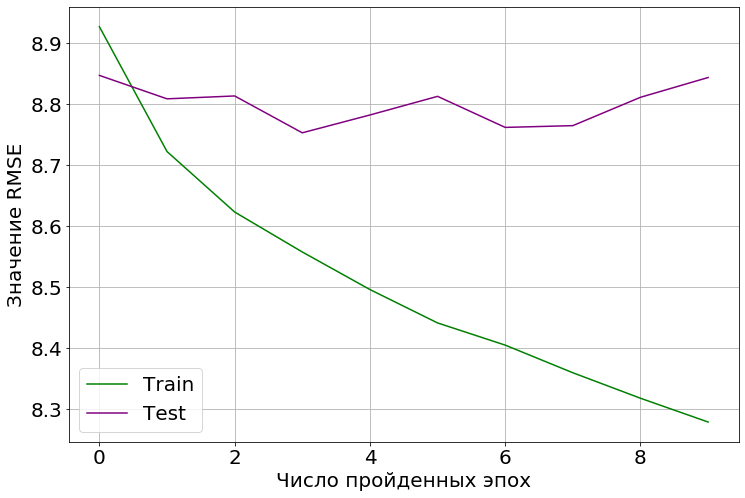

In [44]:
plt.figure(figsize=(12, 8))
plt.plot(metrics_dict['Train RMSE'], color='green', label='Train')
plt.plot(metrics_dict['Test RMSE'], color='purple', label='Test')
plt.xlabel('Число пройденных эпох')
plt.legend()
plt.grid()
plt.ylabel('Значение RMSE')
plt.rcParams['font.size'] = 20
plt.show()

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Перебор всех гиперпараметров осуществлялся с помощью библиотеки optuna. После многократных экспериментов выделялись наиболее оптимальные значения: 
1. функции активации -- ReLU6, ReLU, Sigmoid 
2. learning rate -- 0.01 до 0.03
3. число слоев -- 3
4. число нейронов в каждом слое -- 80 до 130
5. dropout и его вероятность -- не требуется
6. методы градиентного спуска - AdamW

Конечно, ввиду небольшого объема данных, на которых происходило обучение и тестирование в optuna, результаты для каждой комбинации гиперпараметров могли сильно разниться. Более того, наименьшая ошибка была намного больше (от 30 и вплоть 200) аналогичных испытаний на полноценном обучении ввиду маленького объема обучаемых и тестируемых данных. Следовательно, общим число экспериментов компенсировало этот недостаток. После осуществлялось тестирование уже на полных выборках в рамках второй части кода - данные нормировались, строилась константная структура на основе лучших данных из первой части, обновлялись значения гиперпараметров и запускалось обучение. 

Стоит отметить, что ограниченные вычислительные возможности техники не позволяли провести вычисления в optuna на большом количестве батчей или для значительного числа комбинаций гиперпараметров. Вследствие этого полученные данные постоянно модифицировались на незначительные проценты с целью достижения более оптимального эффекта. 
Если говорить о всех проведенных экспериментах, то так как они не проводились руками благодаря optuna, можно отметить невошедшие в итоговый вид программы значения гиперпараметров:
1. Tanh, SortPlus, отсутсвие функции активации
2. [0.0001, 0.1]
3. [1, 6]
4. [4, 200]
5. dropout(p) для каждого слоя / одного слоя / двух слоев $p \in [0.001, 0.3]$
6. Adam, Adagrad, SGD, RMSprop

Так как не имеется классических примеров экспериментов, можем отметить наиболее яркие тренды:

1. Adagrad поднимал значительно изначальные значения ошибки на обучении.
2. Dropout давал одни из лучших результатов на тесте в определенный момент. При этом встречались неожиданные выбросы, когда много нейронов одновременно выпадало.
3. Нейронной сети не было особой разницы на количество слоев при их количестве большем или равном трем.
4. Чрезмерно большой lr уводил градиентный спуск от возможных минимумов, перепрыгивая все и вся.
5. Без нормировки таргета значение ошибки на тесте не опускалось ниже 8.8 ни разу.


Пример архитектуры модели для эксперимента на 6 баллов с lr = 0.01 и без нормировки таргета:

Обучающая ошибка была в районе 8.76, тестовая - 8.87

In [96]:
'''
self.sequential = nn.Sequential(
        nn.Linear(in_features, 93),
        nn.BatchNorm1d(num_features=93),
        nn.ReLU6(),
        nn.Linear(93, 96),
        nn.BatchNorm1d(num_features=96),
        nn.ReLU(),
        nn.Linear(96, 94),
        nn.BatchNorm1d(num_features=94),
        nn.Sigmoid(),
        nn.Linear(94, 67),
        nn.BatchNorm1d(num_features=67),
        nn.Sigmoid(),
        nn.Linear(67, 113),
        nn.BatchNorm1d(num_features=113),
        nn.Sigmoid(),
        nn.Linear(113, self.out_features),
    )
'''

'\nself.sequential = nn.Sequential(\n        nn.Linear(in_features, 93),\n        nn.BatchNorm1d(num_features=93),\n        nn.ReLU6(),\n        nn.Linear(93, 96),\n        nn.BatchNorm1d(num_features=96),\n        nn.ReLU(),\n        nn.Linear(96, 94),\n        nn.BatchNorm1d(num_features=94),\n        nn.Sigmoid(),\n        nn.Linear(94, 67),\n        nn.BatchNorm1d(num_features=67),\n        nn.Sigmoid(),\n        nn.Linear(67, 113),\n        nn.BatchNorm1d(num_features=113),\n        nn.Sigmoid(),\n        nn.Linear(113, self.out_features),\n    )\n'

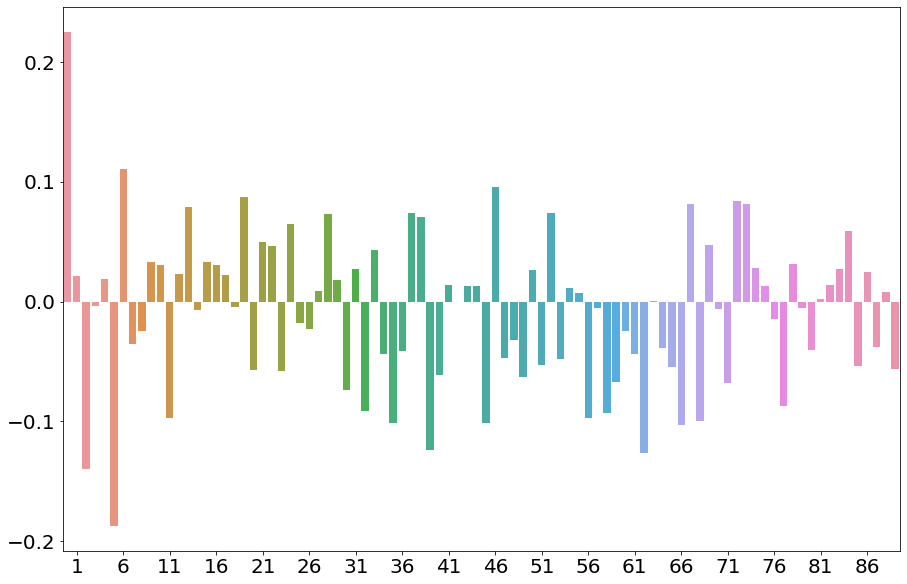

In [109]:
correlations = df.loc[:, 1:].corrwith(df.loc[:, 0]).sort_values(ascending=False)
plot = sns.barplot(x=correlations.index, y=correlations)
plot.figure.set_size_inches(15, 10)
plt.xticks(range(1, len(set(correlations.index)), 5), list(set(correlations.index))[::5])
plt.show()